# Análisis de producción de Sinaloa

### Importar librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from openpyxl import load_workbook
import numpy as np
import geopandas as gpd
from matplotlib.gridspec import GridSpec


### Extracción de valores de siembra y cosecha de camarón

Leer un archivo '.xlsx' con diversas hojas con información relacionada entre sí. 

In [2]:
# Crear una lista con los nombres de cada hoja del archivo 'producción_Sinaloa.xlsx'

file = '''producción_Sinaloa.xlsx'''

# Enlistar el nombre de cada hoja del archivo de Excel

sheet_name = load_workbook ( file , read_only= True ).sheetnames 

# Crear un diccionario que contenga cada tabla del archivo 'producción_Sinaloa' con el nombre de la llave de su respectiva 
# hoja

dfs = { i : pd.read_excel ( file , sheet_name = i )  for i in sheet_name  }

# Eliminar columnas basura de tabla de fecha y 'NA'

dfs [ 'fecha de actualización' ] = dfs [ 'fecha de actualización' ] [ ['Folio' , 'Fecha de actualización'] ].dropna()


Ingresar la fecha a cada tabla uniendo las tablas con la tabla 'fecha de actualización' para posteriormente realizar el análisis a través del tiempo

In [3]:
# Crea un loop for que recorra la lista de nombre de las tablas según la lista sheet_name a excecpción del último elemento 
# de la lista que corresponde a 'fecha de actualización'

for i in range ( len ( sheet_name ) ) [ : -1 ] : 

    # Utilizar merge para unir las tablas, dentro del diccionario dfs (key = i), según la columna folio_fecha de las tablas 
    # y folio de la tabla de fechas. Posteriormente, eliminar columnas inservibles

    m = dfs [ sheet_name [ i ] ].merge ( dfs [ sheet_name [ -1 ] ] , 
                                        left_on= 'folio_fecha' , right_on = 'Folio' 
                                        ).drop ( columns = [ 'folio' , 'Folio' , ] ) 

    # Cambiar el orden de las columnas para que la columna fecha de actualización sea la primera

    m = m [ [ m.columns.to_list () [ -1] ] +  ( m.columns.to_list () [ : -1] ) ]

    # Sobreescribir en dict dfs

    dfs [ sheet_name [ i ] ] = m



Crear variables con los diferentes DataFrames del diccionario dfs para el posterior análisis

In [4]:
semi_siembra = dfs [ 'semi-intensivo']

semi_cosecha = dfs [ 'semi-intensivo-cosecha' ]

hiper_siembra = dfs [ 'hiper_intensivo' ]

hiper_cosecha = dfs [ 'hiper_intensivo_cosecha' ]

### Obtención de datos geométricos del mapa sinaloa

In [5]:
# pth = "E:/794551067314_s/25_sinaloa/conjunto_de_datos/25mun.dbf"

# Definir el nombre del archivo de datos y crear dataframe con geopandas
pth = "25mun.shx"

tracts = gpd.GeoDataFrame.from_file(pth)

# Organizar en orden alfabético

tracts = tracts.sort_values ( 'CVE_MUN')

# Añadir columna 'jsla' para posteriormente aplicar merge entre la tabla de siembra y los datos geométricos

tracts [ 'jsla' ] = [ 'ahome' , 'angostura' , 'badiraguato' , 'concordia' , 'cosala' , 'culiacán' , 'choix' , 'elota' , 
                     'escuinapa' , 'el fuerte' , 'guasave' , 'mzt-san ignacio' , 'mocorito' , 'rosario' , 'salvador alvarado' ,
                      'mzt-san ignaco' , 'sinaloa' , 'navolato' ]

tracts.head(3)

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,jsla
17,25001,25,001,Ahome,"POLYGON ((1804382.444 1610962.613, 1804402.434...",ahome
15,25002,25,002,Angostura,"MULTIPOLYGON (((1861565.220 1471194.549, 18615...",angostura
3,25003,25,003,Badiraguato,"POLYGON ((1959299.447 1575330.583, 1960926.416...",badiraguato


### Análisis de cultivo semi intensivo de Sinaloa

Se crea una tabla general con los valores de hectáreas sembradas y granjas sembradas totales

In [6]:
# Selleccionar columnas necesarias

ha_sembradas = semi_siembra [ [ 'ciclo' , 'hectareas_sembradas_periodo' , 'granjas_sembradas_preriodo'  ] ].groupby ( 'ciclo' ).sum().reset_index()

# Cambiar el tipo de dato de la columna ciclo para posteriormente incluir una fila adicional con el total

ha_sembradas ['ciclo'] = ha_sembradas ['ciclo'].astype ( 'str' )


ha_sembradas.loc[3] = ['total' , ha_sembradas [ 'hectareas_sembradas_periodo'].sum()  , ha_sembradas [ 'granjas_sembradas_preriodo'].sum() ]

# Obtener el porcentaje de hectareas sembradas respecto al total

ha_sembradas ['porcentaje'] = ha_sembradas [ 'hectareas_sembradas_periodo' ] / ha_sembradas['hectareas_sembradas_periodo'].iloc [ 3 ]*100

# Obtener el porcentaje de hectareas sembradas respecto al primer periodo

ha_sembradas ['porcentaje_primer_ciclo'] = ha_sembradas [ 'hectareas_sembradas_periodo' ] / ha_sembradas['hectareas_sembradas_periodo'].iloc [ 0 ]*100

# Redondear valores

ha_sembradas ['hectareas_sembradas_periodo'] = ha_sembradas ['hectareas_sembradas_periodo'].round ( 0 )

for i in [ 'porcentaje' , 'porcentaje_primer_ciclo' ] :

    ha_sembradas [ i ] = ha_sembradas [ i ].round (2)

ha_sembradas

,ciclo,hectareas_sembradas_periodo,granjas_sembradas_preriodo,porcentaje,porcentaje_primer_ciclo
0,1,53437.0,853,61.99,100.00
1,2,32085.0,586,37.22,60.04
2,3,683.0,40,0.79,1.28
3,total,86205.0,1479,100.00,161.32


In [7]:
#Hectáreas totales sembradas y por ciclo y zona

ha_sembradas_2 = semi_siembra [ [ 'jsla' ,  'hectareas_sembradas_periodo' , 'ciclo' , 'granjas_sembradas_preriodo' , 'densidad' ] ].groupby ( [ 'ciclo' , 'jsla' ] ).sum().reset_index()

ha_sembradas_2 ['ciclo'] = ha_sembradas_2 ['ciclo'].astype ( 'str' )

# ha_sembradas.loc[3] = ['total' , ha_sembradas [ 'hectareas_sembradas'].sum() ]

ha_sembradas_2.sort_values ( 'jsla' ).reset_index( drop = True)

ha_sembradas_2 [ 'porcentaje_total_primer_ciclo'] = ha_sembradas_2 [ 'hectareas_sembradas_periodo'] / ha_sembradas['hectareas_sembradas_periodo'].iloc [ 0 ]*100

primer_ciclo = ha_sembradas_2.query(''' ciclo == '1' ''') [ [ 'jsla' , 'hectareas_sembradas_periodo' ] ].rename ( columns = { 'hectareas_sembradas_periodo' : 'ha' })

ha_sembradas_2 = ha_sembradas_2.merge ( primer_ciclo , right_on= 'jsla' , left_on = 'jsla' ).reset_index ( drop = True )

ha_sembradas_2 [ 'procentaje_resp_primer_ciclo_reg'] = ha_sembradas_2 [ 'hectareas_sembradas_periodo'] / ha_sembradas_2 [ 'ha' ] *100

ha_sembradas_2 = ha_sembradas_2.drop ( columns = ['ha'] )#.sort_values('ciclo')

ha_sembradas_2.query ( '''ciclo == ('2' , '3' ) ''' ).sort_values ( 'ciclo' )

ha_sembradas_2 [ 'hectareas_sembradas_periodo' ] = ha_sembradas_2 [ 'hectareas_sembradas_periodo'].round(0)

ha_sembradas_2

,ciclo,jsla,hectareas_sembradas_periodo,granjas_sembradas_preriodo,densidad,porcentaje_total_primer_ciclo,procentaje_resp_primer_ciclo_reg
0,1,ahome,11844.0,96,364,22.163632,100.000000
1,2,ahome,3700.0,36,96,6.923948,31.240132
2,1,angostura,6659.0,86,319,12.461291,100.000000
3,2,angostura,5522.0,70,181,10.333365,82.923709
4,1,culiacán,8852.0,324,578,16.564571,100.000000
5,2,culiacán,6367.0,250,314,11.915545,71.933919
6,3,culiacán,470.0,34,79,0.878605,5.304120
7,1,elota,1560.0,26,174,2.919887,100.000000
8,2,elota,1047.0,22,115,1.959878,67.121707
9,3,elota,69.0,3,14,0.129124,4.422226


In [8]:
cosecha = semi_cosecha.copy ( ) [ [ 'Fecha de actualización' , 'jsla' , 'ciclo' , 'granjas_cosechadas_periodo' , 'fca' , 'kg_ha' , 'peso' , 'sobrevivencia' ] ]

cosecha

,Fecha de actualización,jsla,ciclo,granjas_cosechadas_periodo,fca,kg_ha,peso,sobrevivencia
0,2023-05-31 00:00:00,ahome,1,0,0.00,0.0,0.0,0.0
1,2023-05-31 00:00:00,guasave,1,0,0.00,0.0,0.0,0.0
2,2023-05-31 00:00:00,guasave,1,0,0.00,0.0,0.0,0.0
3,2023-05-31 00:00:00,angostura,1,0,0.00,0.0,0.0,0.0
4,2023-05-31 00:00:00,navolato,1,0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
460,2023-11-29 00:00:00,culiacán,1,0,1.10,814.4,14.6,50.0
461,2023-11-29 00:00:00,elota,1,0,0.73,563.3,15.6,52.0
462,2023-11-29 00:00:00,mzt-san ignacio,1,0,1.81,387.4,15.8,47.0
463,2023-11-29 00:00:00,escuinapa,1,1,1.86,1395.2,12.7,49.0


In [9]:
#Agrupar por region y ciclo

df2 = ha_sembradas_2.copy().drop ( columns = [ 'densidad' ] )

# df2= df2.groupby ( ['jsla' , 'ciclo'] ).sum().reset_index ()


df2

,ciclo,jsla,hectareas_sembradas_periodo,granjas_sembradas_preriodo,porcentaje_total_primer_ciclo,procentaje_resp_primer_ciclo_reg
0,1,ahome,11844.0,96,22.163632,100.000000
1,2,ahome,3700.0,36,6.923948,31.240132
2,1,angostura,6659.0,86,12.461291,100.000000
3,2,angostura,5522.0,70,10.333365,82.923709
4,1,culiacán,8852.0,324,16.564571,100.000000
5,2,culiacán,6367.0,250,11.915545,71.933919
6,3,culiacán,470.0,34,0.878605,5.304120
7,1,elota,1560.0,26,2.919887,100.000000
8,2,elota,1047.0,22,1.959878,67.121707
9,3,elota,69.0,3,0.129124,4.422226


In [10]:
pallete = sns.color_palette ('Blues')

pallete_2 = sns.color_palette ( 'Blues_r' )

pallete_3 = sns.color_palette ( 'GnBu' )

pallete_4 = sns.color_palette ( 'BuPu' )

In [26]:
def fc(x):
    """
    Formats an integer with commas as thousand separators.
    """
    return f"{x:,}"

#numeros de barras


def info_bars ( fig , fontsi = False , some_arg = False , weight = False ) : 
     
     if some_arg == False :
        
        some_arg = ''
     
     for c in fig.containers :

        labels = [f'{int(w)} {some_arg}' if (w := v.get_width()) > 0 else '' for v in c ]
        
        # set the bar label
        fig.bar_label(c, labels=labels, label_type='edge' , padding= 10 , fontsize = fontsi , weight = weight )

    # if some_arg == False:
    
    #     some_arg = ''

    # for p in figure.patches :

    #     if p.get_width () != 0 :
        
    #         figure.annotate  ( str ( fc ( int ( np.around( p.get_width() ) ) ) ) + some_arg , ( p.get_width() + n_space , p.get_y() * 1.0005  ) ,  fontsize = fontsi , horizontalalignment = 'center' , weight = weight )

def info_bars_v ( figure , n_space , fontsi = False , some_arg = False , x = False , weight = False ) : 

    if x == False :
        x = 1.0005

    if some_arg == False:
    
        some_arg = ''

    for p in figure.patches :

        if p.get_height() != 0 :
        
            figure.annotate  ( str ( fc (int ( np.around( p.get_height() ) ) ) ) + some_arg , ( p.get_x() + x  ,  p.get_height() + n_space ) , fontsize = fontsi , horizontalalignment = 'center' , weight = weight  )

def info_bars_op ( figure , figure_2 , n_space , fontsi = False , some_arg = False , x = False , weight = False ) : #vertical

    if x == False :
        x = 1.0005

    if some_arg == False:
    
        some_arg = ''

    for p,q in zip (figure_2.patches , figure.patches ) :

        if p.get_height() != 0 :

            # for q in figure.patches :

                # if p.get_height() != 0 :
        
                    figure.annotate  ( str ( fc (int ( np.around( p.get_height() ) ) ) ) + some_arg , ( p.get_x() + x ,  q.get_height() + n_space ) ,
                                       fontsize = fontsi , horizontalalignment = 'center' , weight = weight , color = 'steelblue' )



def truncate (x):

    return np.truncate ( x,0)


(1684986.287221629, 2583425.2531212247)

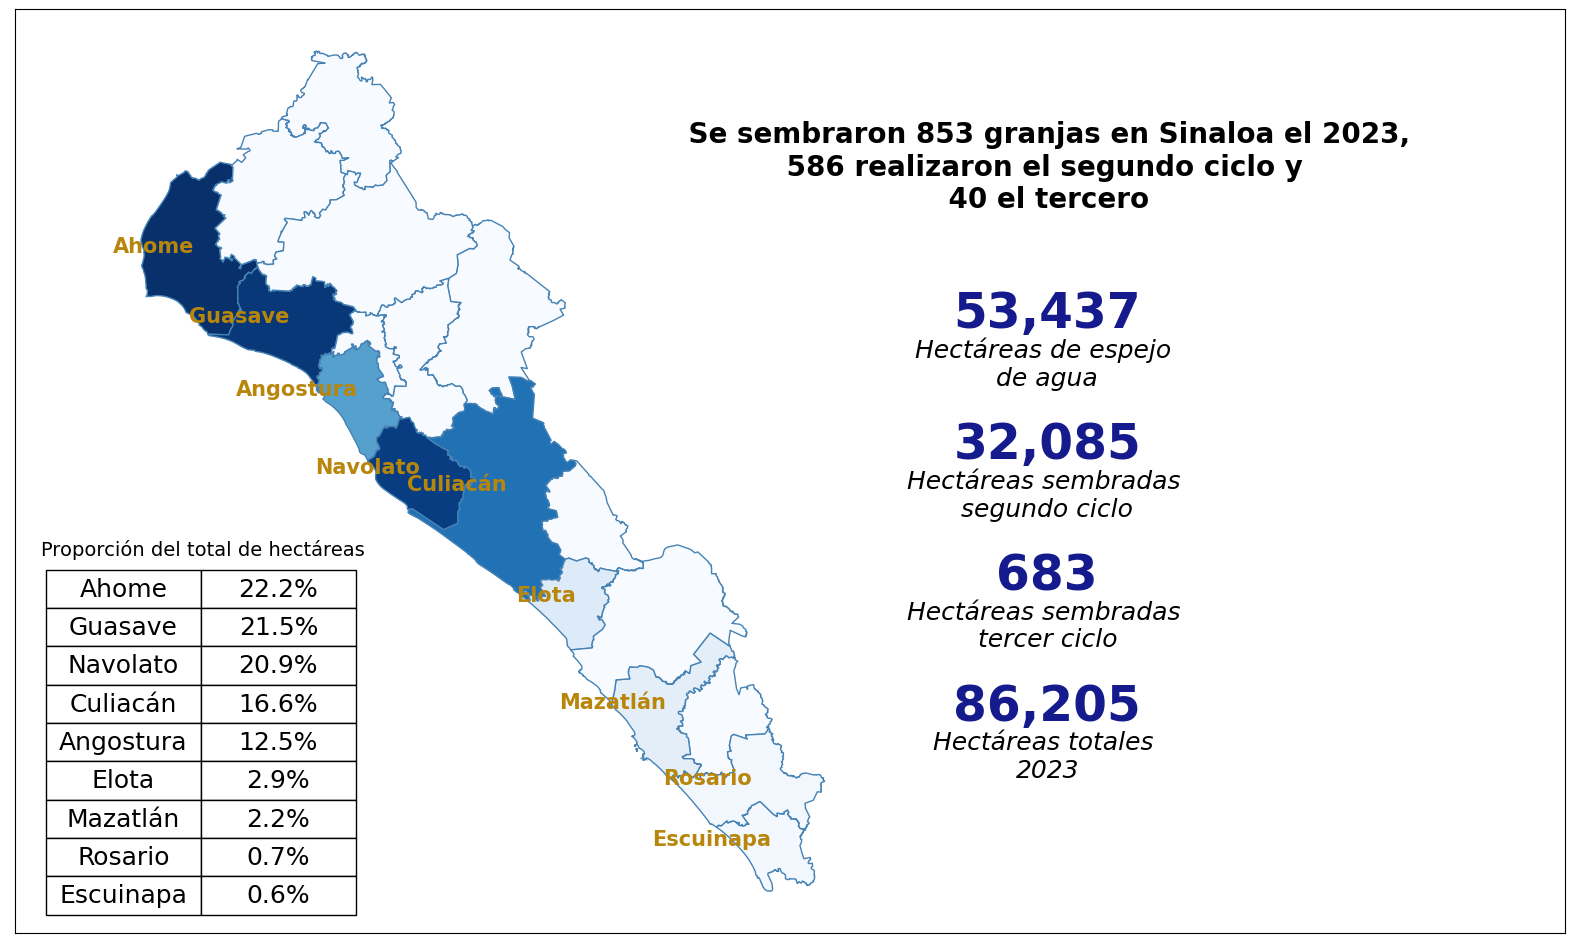

In [12]:
#Hectareas totales
prop = df2 [ [ 'ciclo' , 'jsla' , 'porcentaje_total_primer_ciclo' ] ].query ( ''' ciclo  ==  '1' ''').set_index ( 'jsla' ).drop ( columns= ( 'ciclo' ) ).sort_values ( 'porcentaje_total_primer_ciclo')


figure , axes = plt.subplots (  1 , 1 , figsize = ( 20 , 12 ) )


plog = tracts.join ( prop , 'jsla' ).fillna (0) # left_on = 'jsla' , right_on = 'jsla' )

plog [ 'porcentaje_total_primer_ciclo' ] = plog [ 'porcentaje_total_primer_ciclo' ].round(1)

plog['coords'] = plog['geometry'].apply(lambda x: x.centroid.coords[:])
plog['coords'] = [coords[0] for coords in plog['coords']]

map = plog.plot('porcentaje_total_primer_ciclo', edgecolor = 'steelblue',  cmap = 'Blues',  ax = axes   )#, #categorical = True )


for idx , row in  plog.iterrows () :

    if row [ 'porcentaje_total_primer_ciclo' ] != 0 :

        name = row [ 'NOMGEO'] #+ '\n' + str (  row [ 'porcentaje_total_primer_ciclo' ] ) + '%'
        map.annotate ( name ,
                        row [ 'coords' ]  , 
                        horizontalalignment='right', 
                        color = 'darkgoldenrod' , 
                        weight = 'bold', 
                        fontsize = 15
                        )
map.get_xaxis().set_visible(False)
map.get_yaxis().set_visible(False)

granjas_ciclo1 = ha_sembradas.query ( '''ciclo == '1' ''' ) [ 'granjas_sembradas_preriodo'] [ 0 ]
granjas_ciclo2 = ha_sembradas.query ( '''ciclo == '2' ''' ) [ 'granjas_sembradas_preriodo'] [ 1 ]
granjas_ciclo3 = ha_sembradas.query ( '''ciclo == '3' ''' ) [ 'granjas_sembradas_preriodo'] [ 2 ]

ha_ciclo1 = ha_sembradas.query ( '''ciclo == '1' ''' ) [ 'hectareas_sembradas_periodo'] [ 0 ]
ha_ciclo2 = ha_sembradas.query ( '''ciclo == '2' ''' ) [ 'hectareas_sembradas_periodo'] [ 1 ]
ha_ciclo3 = ha_sembradas.query ( '''ciclo == '3' ''' ) [ 'hectareas_sembradas_periodo'] [ 2 ]
ha_ciclot = ha_sembradas.query ( '''ciclo == 'total' ''' ) [ 'hectareas_sembradas_periodo'] [ 3 ]

txt_intro = f'''
    Se sembraron {granjas_ciclo1} granjas en Sinaloa el 2023,
    {granjas_ciclo2} realizaron el segundo ciclo y 
    {granjas_ciclo3} el tercero
    
'''
color_numbers = '#151B8D'
map.annotate ( txt_intro , ( 2273425.2531212247, 1543986.287221629 ) ,  horizontalalignment = 'center' , fontsize = 20 , weight = 'bold' )

#Hectareas primer ciclo label
map.annotate ( str ( fc(int ( ha_ciclo1 ))  ) , ( 2283425.2531212247, 1509986.287221629 ) , 
              horizontalalignment = 'center', fontsize = 35 , color = color_numbers , weight = 'bold'  )
map.annotate ( 'Hectáreas de espejo \nde agua' , ( 2283425.2531212247, 1474986.287221629 ) , horizontalalignment = 'center' , fontsize = 18 , style = 'italic' )
# map.annotate ( '(siembra del primer ciclo)' , ( 2283425.2531212247, 1490986.287221629 ) , horizontalalignment = 'center' , fontsize = 14 , style = 'italic' )

#Hectáreas segundo ciclo label
map.annotate ( str ( (fc (int ( ha_ciclo2 ) ) ) ) , ( 2283425.2531212247, 1429986.287221629 ) , 
              horizontalalignment = 'center', fontsize = 35 , color = color_numbers , weight = 'bold'  )
map.annotate ( 'Hectáreas sembradas \nsegundo ciclo' , ( 2283425.2531212247, 1394986.287221629 ) , horizontalalignment = 'center' , fontsize = 18 , style = 'italic' )

#Hectáreas sembradas 3 ciclo

map.annotate ( str ( fc ( int ( ha_ciclo3 ) ) ) , ( 2283425.2531212247, 1349986.287221629 ) , 
              horizontalalignment = 'center', fontsize = 35 , color = color_numbers , weight = 'bold'  )
map.annotate ( 'Hectáreas sembradas \ntercer ciclo' , ( 2283425.2531212247, 1314986.287221629 ) , horizontalalignment = 'center' , fontsize = 18 , style = 'italic' )

#Hectáreas totales

map.annotate ( str ( fc ( int ( ha_ciclot  ) ) ) , ( 2283425.2531212247, 1269986.287221629 ) , 
              horizontalalignment = 'center', fontsize = 35 , color = color_numbers , weight = 'bold'  )
map.annotate ( 'Hectáreas totales \n2023' , ( 2283425.2531212247, 1234986.287221629 ) , horizontalalignment = 'center' , fontsize = 18 , style = 'italic' )


#Table

map.annotate ( 'Proporción del total de hectáreas' , ( 1793821.8624098692 , 1370854.0398249433 ) , horizontalalignment = 'center' , fontsize = 14 )

info_table = plog [ [ 'NOMGEO' , 'porcentaje_total_primer_ciclo' ] ].query ( ''' porcentaje_total_primer_ciclo  > 0 ''' ).sort_values ( 'porcentaje_total_primer_ciclo' , ascending = False )
info_table [ 'porcentaje_total_primer_ciclo' ] = info_table [ 'porcentaje_total_primer_ciclo' ].astype (str) + '%'

table = axes.table ( cellText = info_table.values , loc = 'lower left' , cellLoc='center' ) #, rowColours =  )

table.scale ( .2, 2.3 )
table.set_fontsize ( 20 )
axes.axis('tight')

#Set figure xlim
axes.set_xlim ( 1684986.287221629 , 2583425.2531212247 )




In [13]:
ha_sembradas#.query ( '''ciclo == 'Total' ''' )# [ 'hectareas_sembradas_periodo']

,ciclo,hectareas_sembradas_periodo,granjas_sembradas_preriodo,porcentaje,porcentaje_primer_ciclo
0,1,53437.0,853,61.99,100.00
1,2,32085.0,586,37.22,60.04
2,3,683.0,40,0.79,1.28
3,total,86205.0,1479,100.00,161.32


In [14]:

#Hectareas sembradas por ciclo
ciclo  = df2[ ['ciclo' , 'jsla' , 'hectareas_sembradas_periodo' ] ].set_index ('jsla' ).pivot(columns=( 'ciclo' ))  

ciclo [ 'Total' ] = ciclo.sum ( axis= 1)

# ciclo = ciclo [[ (                      'Total',  '') , ('hectareas_sembradas_periodo', '3') , ('hectareas_sembradas_periodo', '2') , ('hectareas_sembradas_periodo', '1') ]].sort_values ( (                       'Total',  '' )  , ascending= True )

ciclo = ciclo [[ ( 'Total',  '')  , ('hectareas_sembradas_periodo', '3') , ('hectareas_sembradas_periodo', '2') , ('hectareas_sembradas_periodo', '1')   ]].sort_values ( (                       'Total',  '' )  , ascending= True )

ciclo [ 'Ciclo 2 vs Ciclo 1'   ] = ciclo [ ('hectareas_sembradas_periodo', '2') ] / ciclo [ ('hectareas_sembradas_periodo', '1') ] * 100

ciclo [ 'Ciclo 3 vs Ciclo 2' ] = ciclo [ ('hectareas_sembradas_periodo', '3') ] / ciclo [ ('hectareas_sembradas_periodo', '2') ] * 100

ciclo = ciclo.rename ( index= { 'escuinapa' : 'Escuinapa' , 'rosario' : 'Rosario' , 'mzt-san ignacio' : 'Mzt-SI' , 'elota' : 'Elota' , 'angostura' : 'Angostura' , 'ahome' : 'Ahome' , 'culiacán' : 'Culiacán' ,
                       'guasave' : 'Guasave' , 'navolato' : 'Navolato'
                       })

#Fig 2 plot df

fig_2_df = ciclo [ [ 'Ciclo 3 vs Ciclo 2' , 'Ciclo 2 vs Ciclo 1'   ] ].query ( '''index in ( 'Guasave' , 'Ahome' , 'Navolato' , 'Culiacán' , 'Angostura' ) ''' ).sort_values ( 'Ciclo 2 vs Ciclo 1' ).fillna(0)

fig_2a_df = ciclo [ [ 'Ciclo 3 vs Ciclo 2' , 'Ciclo 2 vs Ciclo 1'  ] ].query ( '''index not in ( 'Guasave' , 'Ahome' , 'Navolato' , 'Culiacán' , 'Angostura' ) ''' ).sort_values ( 'Ciclo 2 vs Ciclo 1' ).fillna(0)



Text(110, 3, 'C)')

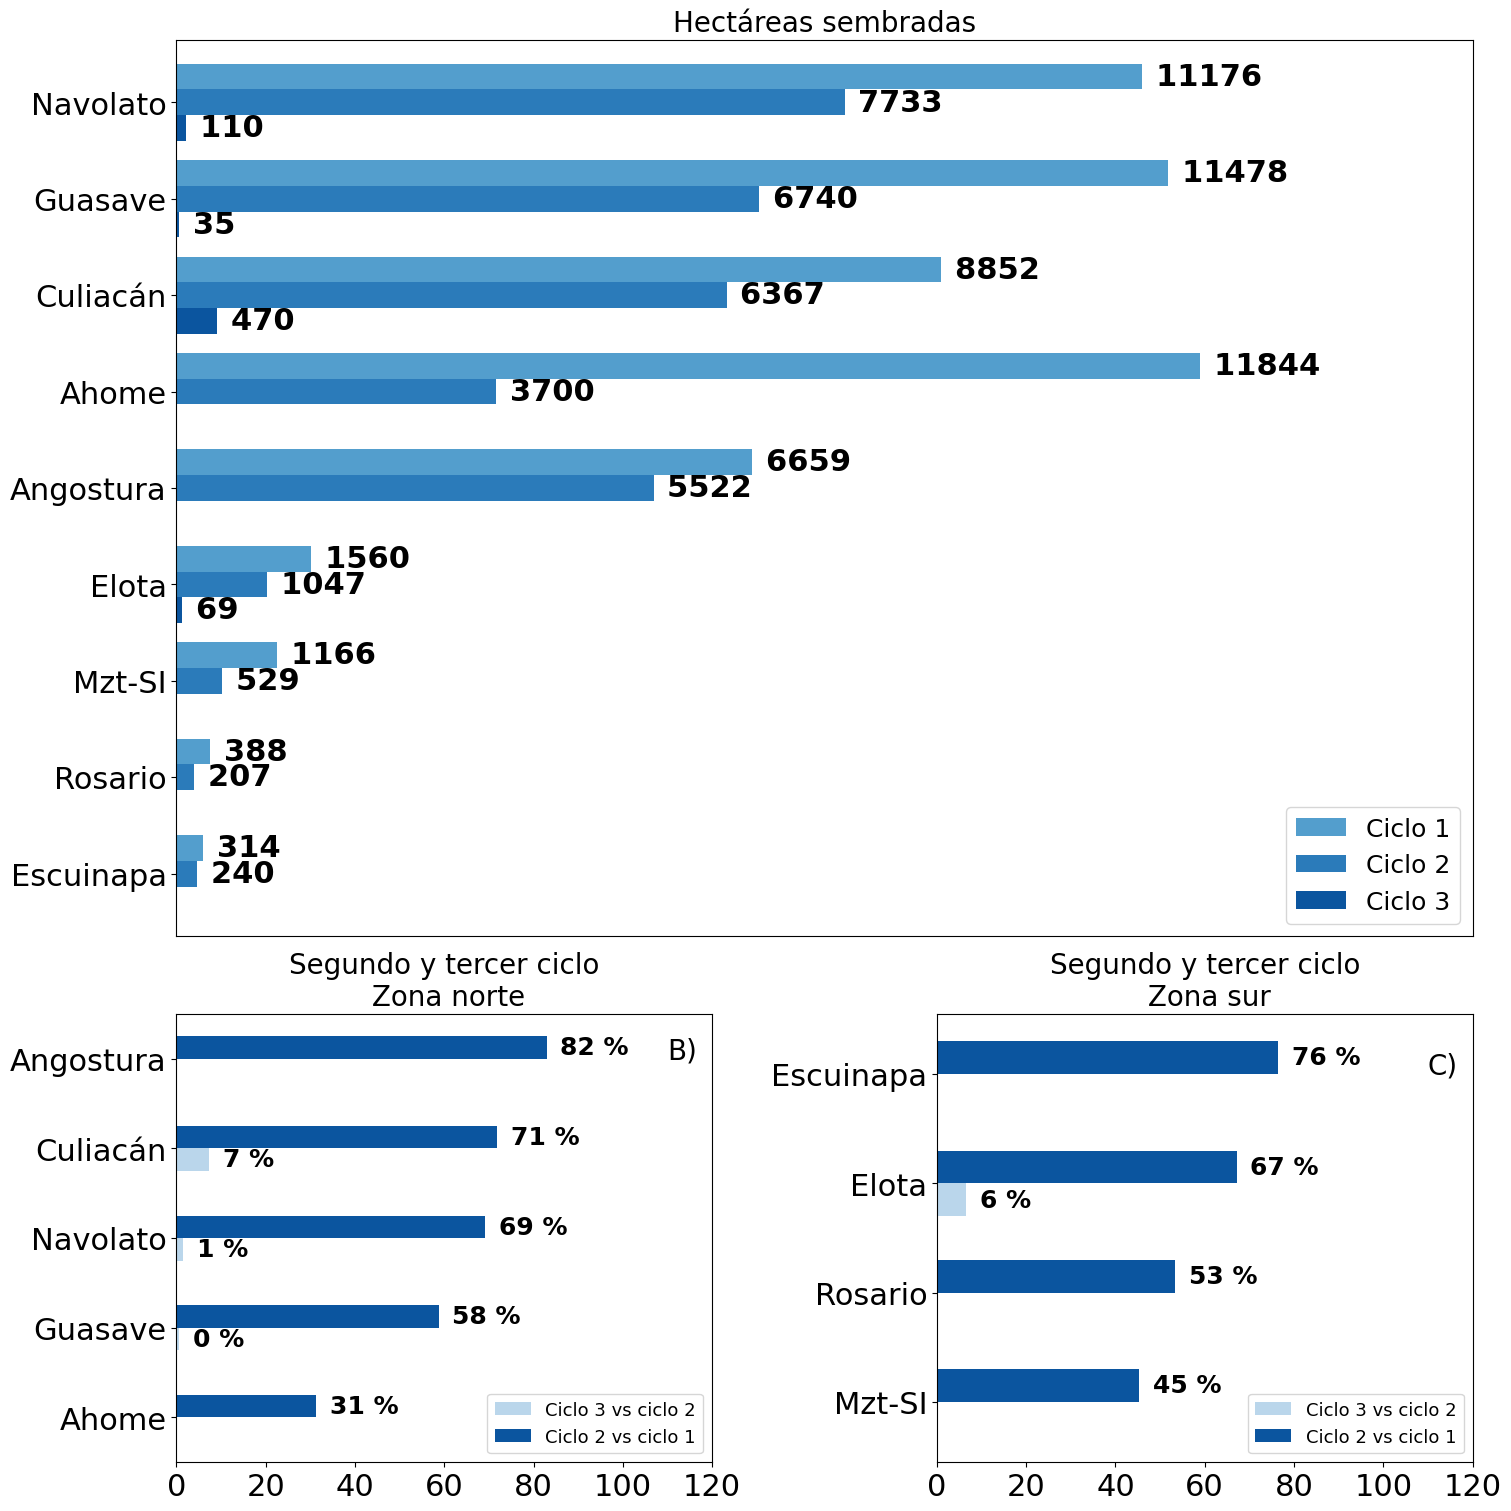

In [29]:
figure_5 = plt.figure ( layout="constrained" , figsize= ( 15 , 15) )

# from matplotlib.gridspec import GridSpec

gs = GridSpec ( 3 , 2 , figure = figure_5   )

ax1 = figure_5.add_subplot(gs[0:2, : ])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

ax2 = figure_5.add_subplot(gs[2, :-1])
ax3 = figure_5.add_subplot(gs[2:, -1])



# fig = ciclo.drop ( columns = [ (                      'Total',  '') , (         'Ciclo 2 vs Ciclo 1',  ''), (         'Ciclo 3 vs Ciclo 2',  '')] ).plot.barh ( color= pallete_2  , stacked = True , xlabel = '' , fontsize = 22 , ax = ax1 , width = 0.8 )
# ax1.set_title ( 'Hectáreas sembradas' )
# ax1.title.set_size (20)
# info_bars (fig, 800 , 22 , weight = 'bold' )
# fig.set_xlim ( 0, 23000)
# fig.set_ylim ( 0 , 9.2 )
fig = ciclo.drop ( columns = [ ('Total',  '') , ('Ciclo 2 vs Ciclo 1',  ''), ('Ciclo 3 vs Ciclo 2',  '')] ).plot.barh ( color= pallete_2  , stacked = False , xlabel = '' 
                                                                                                                                                              , fontsize = 22 , ax = ax1 , width = 0.8 )

ax1.set_title ( 'Hectáreas sembradas' )
# ax1.invert_yaxis()

ax1.title.set_size (20)

info_bars (fig, fontsi = 22 , weight = 'bold' )


# for c in fig.containers :

#     labels = [f'{w}' if (w := v.get_width()) > 0 else '' for v in c ]
    
#     # set the bar label
#     fig.bar_label(c, labels=labels, label_type='edge' , padding= 10 , fontsize = 18 )

fig.set_xlim ( 0, 15000)
# fig.legend   ( [ 'Ciclo 3' , 'Ciclo 2' , 'Ciclo 1'  ] ,  loc = 'lower right' , title = False , fontsize = 18 )
fig.get_xaxis().set_visible(False)

#Change order of labels
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], ['Ciclo 1' , 'Ciclo 2' , 'Ciclo 3' ], loc = 'lower right' , title = False , fontsize = 18 )

fig_2 = fig_2_df.plot.barh ( ax = ax2 , color =  pallete [ 1:2 ] + [pallete_2 [0]] ,  fontsize = 22 , xlabel = '', width = 0.5 )
ax2.set_title ( 'Segundo y tercer ciclo\n Zona norte' )
ax2.title.set_size (20)
info_bars (fig_2 , fontsi = 18 , some_arg = '%' , weight = 'bold' )
fig_2.legend ( [ 'Ciclo 3 vs ciclo 2' , 'Ciclo 2 vs ciclo 1' ] ,  title = False , loc = 'lower right' , fontsize = 13 )
fig_2.set_xlim ( 0 , 120 )

fig_2a = fig_2a_df.plot.barh ( ax = ax3 , color = pallete [ 1:2 ] + [pallete_2 [0]] , title = 'Zona centro/sur' , fontsize = 22 , xlabel = '' , width = 0.6 )
ax3.set_title ( 'Segundo y tercer ciclo\n Zona sur' )
ax3.title.set_size (20)
info_bars (fig_2a , fontsi = 18 , some_arg = '%' , weight = 'bold' )
fig_2a.legend ( [ 'Ciclo 3 vs ciclo 2' , 'Ciclo 2 vs ciclo 1' ] ,  title = False , loc = 'lower right' , fontsize = 13 )
fig_2a.set_xlim ( 0 , 120 )

#Indice figuras
ax1.annotate ( 'A)' , ( 22000 , 8.1 ) , fontsize = 20 )
ax2.annotate ( 'B)' , ( 110 , 4 ) , fontsize = 20 )
ax3.annotate ( 'C)' , ( 110 , 3 ) , fontsize = 20 )

A través del tiempo

In [17]:
time_line = semi_siembra [ [ 'Fecha de actualización' , 'jsla' , 'ciclo' , 'hectareas_sembradas_periodo' , 'granjas_sembradas_preriodo' , 'densidad' ] ]

time_line [ 'mes' ] = pd.DatetimeIndex ( semi_siembra [ 'Fecha de actualización'] ).month

time_line

C:\Users\aldou\AppData\Local\Temp\ipykernel_20552\2190830121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_line [ 'mes' ] = pd.DatetimeIndex ( semi_siembra [ 'Fecha de actualización'] ).month


,Fecha de actualización,jsla,ciclo,hectareas_sembradas_periodo,granjas_sembradas_preriodo,densidad,mes
0,2023-03-15 00:00:00,guasave,1,442.32,7,11,3
1,2023-03-15 00:00:00,guasave,1,595.10,6,10,3
2,2023-03-15 00:00:00,angostura,1,3196.46,38,11,3
3,2023-03-15 00:00:00,navolato,1,2058.30,25,10,3
4,2023-03-15 00:00:00,navolato,1,2571.72,31,11,3
...,...,...,...,...,...,...,...
539,2023-11-08 00:00:00,guasave,3,0.00,0,10,11
540,2023-11-08 00:00:00,navolato,3,0.00,0,8,11
541,2023-11-08 00:00:00,culiacán,3,0.00,0,8,11
542,2023-11-08 00:00:00,culiacán,3,5.00,1,7,11


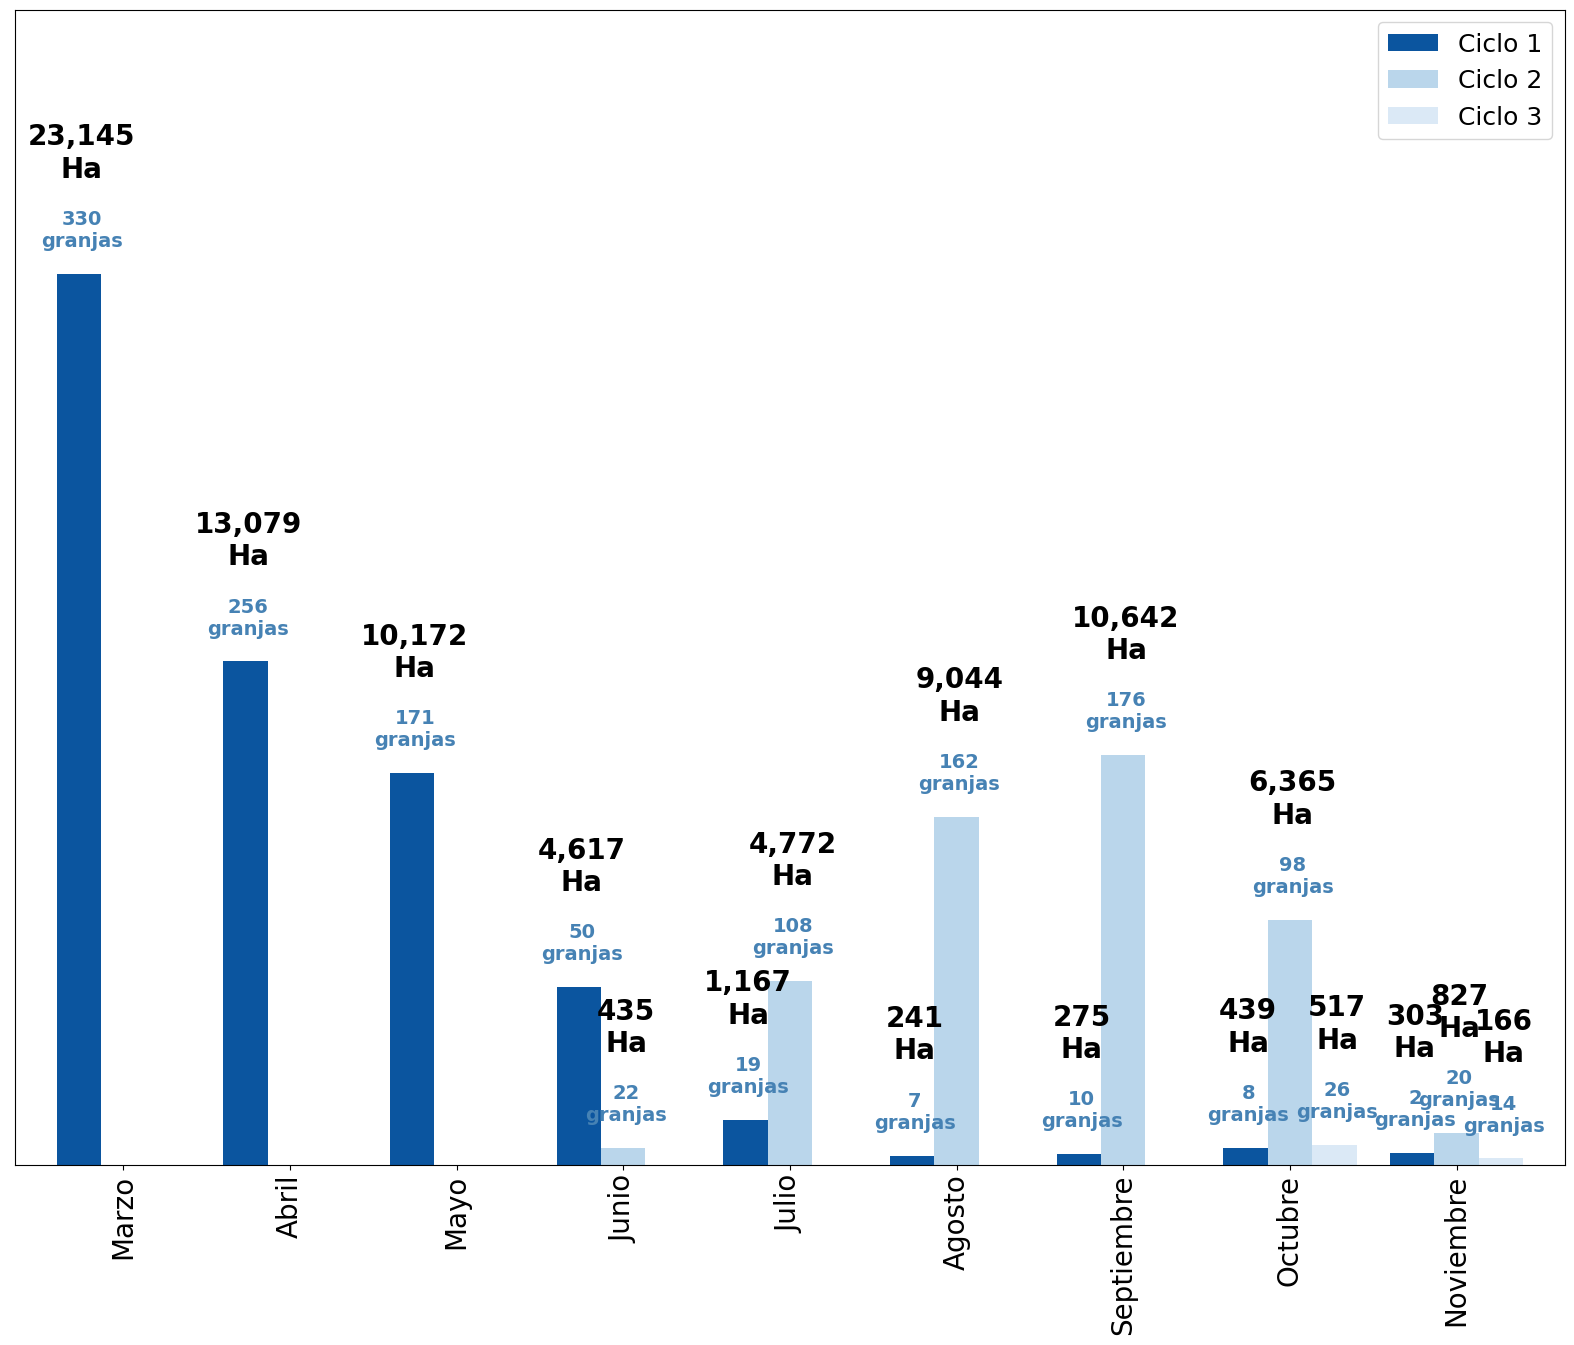

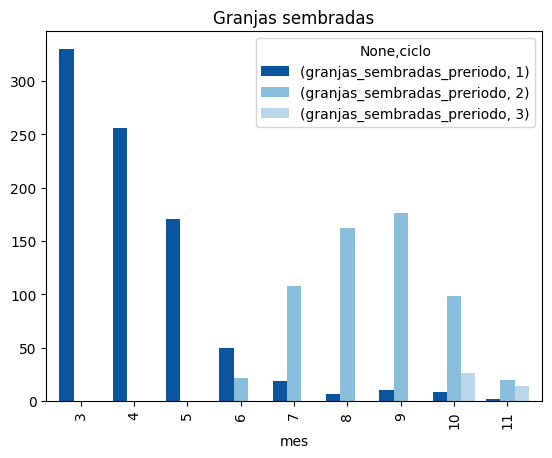

In [18]:
siembra_mensual = time_line.groupby ( [ 'mes' ,  'ciclo' ] ).sum().reset_index ().set_index ('mes')#.rename ( 
    # index = { 3 : 'Marzo' , 4 : 'Abril' , 5 : 'Mayo' , 6 : 'Junio' , 7 : 'Julio' , 8 : 'Agosto' , 9 : 'Septiembre' , 10 : 'Octubre' , 11 : 'Noviembre' } ).sort_index (  'Marzo' , 'Abril' , 'Mayo' , 'Junio' , 'Julio' , 'Agosto' , 'Septiembre' , 'Octubre' , 'Noviembre' )

figure_3 , axes_3 = plt.subplots ( 1 , 1 , figsize = ( 20 , 15 ) )

# figure_3.suptitle ( 'Siembra total por periodo' )

x = 0.15

fig_3 = siembra_mensual [ [ 'ciclo' , 'hectareas_sembradas_periodo' ] ].pivot ( columns = ('ciclo') ).plot.bar ( color= [pallete_2 [0] ] + [pallete [ 1 ] ] + [pallete_2 [ -1 ]] ,
                                                                                                                  ax = axes_3  ,
                                                                                                                  width = .8 , linewidth=1 ,
                                                                                                                  xlabel = '' ,
                                                                                                                  fontsize = 20 ,
                                                                                                                  )#figsize = ( 12, 8 ) )
fig_3.legend ( [ 'Ciclo 1' , 'Ciclo 2' , 'Ciclo 3' ] , title = False , fontsize = 18  )
fig_3.set_ylim ( 0 , 30000)
info_bars_v ( fig_3 , 2500 , 20 , some_arg= '\nHa' ,  x = x , weight = 'bold' )
fig_3.set_xticklabels ( ['Marzo' , 'Abril' , 'Mayo' , 'Junio' , 'Julio' , 'Agosto' , 'Septiembre' , 'Octubre' , 'Noviembre' ] )
fig_3.get_yaxis().set_visible(False)
# fig_3.get_xlabel().set_visible(False)


fig_3a = siembra_mensual [ [ 'ciclo' , 'granjas_sembradas_preriodo' ] ].pivot ( columns = ('ciclo') ).plot.bar ( color= [pallete_2 [0] ] + [pallete_2 [ 3 ] ] + [pallete_2 [ 4 ]] , 
                                                                                                                title = 'Granjas sembradas',
                                                                                                                  width = .8  , linewidth=1 ) # figsize = ( 12, 8 ) )
# fig_3a.legend ( [ 'Ciclo 1' , 'Ciclo 2' , 'Ciclo 3' ] , title = False  )
# info_bars_v ( fig_3a , 10 , 8)
# fig_3a.set_ylim ( 0 , 425 )

info_bars_op ( fig_3 , fig_3a , 700 , 14 , some_arg= '\ngranjas' , x = x , weight = 'bold' )

In [19]:
siembra_mensual.rename ( index = { 3 : 'Marzo' , 4 : 'Abril' , 5 : 'Mayo' , 6 : 'Junio' , 7 : 'Julio' , 8 : 'Agosto' , 9 : 'Septiembre' , 10 : 'Octubre' , 11 : 'Noviembre' } )

,ciclo,hectareas_sembradas_periodo,granjas_sembradas_preriodo,densidad
mes,,,,
Marzo,1,23145.11,330,357
Abril,1,13079.14,256,513
Mayo,1,10171.90,171,388
Junio,1,4616.73,50,524
Junio,2,435.20,22,71
Julio,1,1166.73,19,264
Julio,2,4771.94,108,186
Agosto,1,240.87,7,528
Agosto,2,9043.96,162,505


In [20]:
siembra_mensual [ 'ha_granja' ] = siembra_mensual [ 'hectareas_sembradas_periodo' ] / siembra_mensual [ 'granjas_sembradas_preriodo' ]

siembra_mensual.ha_granja.mean().round(2) , siembra_mensual.ha_granja.std().round(2) , siembra_mensual.ha_granja.max().round(2) , siembra_mensual.ha_granja.min().round(2)

(54.18, 32.55, 151.5, 11.89)

In [21]:
siembra_region = time_line  [ [ 'mes' , 'jsla' , 'ciclo' , 'hectareas_sembradas_periodo' , 'granjas_sembradas_preriodo'  ] ].groupby ( [ 'mes' , 'ciclo' , 'jsla'  ] ).sum().reset_index().set_index ( 'mes' )

# siembra_region 



# lista_regiones = siembra_region.jsla.unique().tolist ()

# for i in lista_regiones :

#     figure_4 , axes_4 = plt.subplots ( 1 , 2 , figsize = ( 15 , 4 ))

#     figure_4.suptitle ( f'Siembra {i}')

#     fig_4_i = siembra_region.query ( ''' jsla == '{}' '''.format (i) )

#     fig_4 = fig_4_i [ [ 'hectareas_sembradas_periodo' , 'ciclo' ] ].pivot ( columns = ('ciclo') ).plot.bar ( ax = axes_4 [ 0 ] , color = [pallete_2 [0] ] + [pallete_2 [ 3 ] ] + [pallete_2 [ 4 ]] , title =  'Hectáreas sembradas' )
#     fig_4.legend ( ['Ciclo 1' , 'Ciclo 2' , 'Ciclo 3'] , title = False)
#     fig_4.set_ylim ( 0 , 8000 )
#     info_bars_v ( fig_4 , 100 , 8)

#     fig_4a = fig_4_i [ [ 'granjas_sembradas_preriodo' , 'ciclo' ] ].pivot ( columns =  ('ciclo') ).plot.bar ( ax = axes_4 [ 1 ] , color = [pallete_2 [0] ] + [pallete_2 [ 3 ] ] + [pallete_2 [ 4 ]] , title = 'Granjas sembradas' )
#     fig_4a.set_ylim ( 0 , 150)
#     fig_4a.legend ( ['Ciclo 1' , 'Ciclo 2' , 'Ciclo 3'] , title = False)
#     info_bars_v ( fig_4a , 1 , 8 )




**Fror

In [22]:
def ob_param_1 ( jsla , parametro ) : 

    return ha_sembradas_2.query ( ''' jsla == '{}' and ciclo == '1' '''.format ( jsla ) )[ parametro ].reset_index ( drop = True ).loc[0]

def map_region ( region ) :
    
    return tracts.query ( ''' NOMGEO == '{}' '''.format ( region ))#.plot()

def param_cosecha ( jsla , parame  ) :

    return  str ( cosecha.query ( ''' jsla == '{}' and {} != 0 '''.format ( jsla , parame ) ) [ parame ].median().round (2) ) + ' ± ' + str ( cosecha.query ( ''' jsla == '{}' and {} != 0 '''.format ( jsla, parame) )[ parame ].std().round (2) )

class Datos_region :

    def __init__ ( self ,  nomgeom , jsla ) : 

        self.region = jsla

        self.map = map_region ( nomgeom )

        self.hectáreas =  fc ( int ( ob_param_1 ( jsla , 'hectareas_sembradas_periodo' ) ) )

        self.granjas = str ( int ( ob_param_1 ( jsla , 'granjas_sembradas_preriodo' ) ) )

        self.densidad =  str ( int ( semi_siembra.query ( ''' jsla == '{}' '''.format ( jsla ) ).densidad.mean ( ).round (0) ) ) + ' ± ' + str ( int ( semi_siembra.query ( ''' jsla == '{}' '''.format (jsla) ).densidad.std ( ).round (0) ) )

        self.fca = param_cosecha ( jsla , 'fca' )

        self.kg_ha = param_cosecha ( jsla , 'kg_ha' )

        self.peso = param_cosecha ( jsla , 'peso' )

        self.sobrevivencia = param_cosecha ( jsla , 'sobrevivencia' )

    def plots  ( self ) :

        figure_6 = plt.figure ( layout="constrained" , figsize= (12,8)  )

        # from matplotlib.gridspec import GridSpec

        gs_2 = GridSpec ( 3 , 4 , figure = figure_6   )

        ax_1 = figure_6.add_subplot(gs_2[ :  , : 2  ])
        ax_2 = figure_6.add_subplot(gs_2[ 0 ,  2: ])
        ax_3 = figure_6.add_subplot(gs_2[ 1 : ,  2: ])

        def sin_bordes ( ax ) :#quita ejes y marco
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.axis('off')

        sin_bordes (ax_1)
        sin_bordes (ax_2)

        #mapa
        tracts.plot ( ax = ax_1 , color = 'white' , edgecolor = '#1569C7' )
        self.map.plot ( ax = ax_1 , color = 'steelblue'  , edgecolor = '#123456' ) #color_numbers )  # , cmap = 'Blues' )


        #Datos

        x1 = 0.2
        x2 = x1 + .33
        x3 = x2 + .3

        y1 = .7
        y2 = y1 - .3
        y3 = y2 - .3

        y4 = y1 + .1
        y5 = y2 + .1
        y6 = y3+.1

        color_etiquete = '#1569C7'
        ax_2.annotate ( 'Ha de espejo de agua' , ( x1 , y1  ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )
        ax_2.annotate ( 'Granjas sembradas' , ( x2 , y1 ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )
        ax_2.annotate ( 'Densidad de siembra' , ( x3 , y1  ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )

        ax_2.annotate ( 'kilogramos / hectárea' , ( x1 , y2 ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )
        ax_2.annotate ( 'Peso de cosecha' , ( x2 , y2  ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )
        ax_2.annotate ( 'FCA' , ( x3 , y2  ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )

        ax_2.annotate ( 'Sobrevivencia' , ( x2 , y3 ) ,  horizontalalignment = 'center' , fontsize = 10 , style = 'italic' , color = color_etiquete )

        ax_2.annotate ( self.hectáreas , ( x1 , y4 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold' )
        ax_2.annotate ( self.granjas , ( x2 , y4  ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )
        ax_2.annotate ( self.densidad , ( x3 , y4 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )

        ax_2.annotate ( self.kg_ha , (x1 , y5 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )
        ax_2.annotate ( self.peso , ( x2 , y5 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )
        ax_2.annotate ( self.fca , ( x3 , y5  ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )

        ax_2.annotate ( self.sobrevivencia , ( x2 , y6 ) ,  horizontalalignment = 'center' , fontsize = 16 , weight = 'bold'  )
        #Siembras 
        # regi = 'ahome'
        fig_4_i = siembra_region.query ( ''' jsla == '{}' '''.format ( self.region ) )

        fig_4 = fig_4_i [ [ 'hectareas_sembradas_periodo' , 'ciclo' ] ].pivot ( columns = ('ciclo') ).plot.bar ( ax = ax_3 , color = [pallete_2 [0] ] + [pallete_2 [ 3 ] ] + [pallete_2 [ 4 ]] , 
                                                                                                                title =  'Hectáreas sembradas' , xlabel = ''  )
        fig_4.legend ( ['Ciclo 1' , 'Ciclo 2' , 'Ciclo 3'] , title = False, fontsize = 16 )
        fig_4.set_ylim ( 0 , 8500 )
        info_bars_v ( fig_4 , 100 , 14 , x = .1)
        ax_3.title.set_size (15)
        ax_3.set_xticklabels ( ['Marzo' , 'Abril' , 'Mayo' , 'Junio' , 'Julio' , 'Agosto' , 'Septiembre' , 'Octubre' , 'Noviembre' ] )



Ahome

In [23]:
#Ahome
#Hectáreas sembradas
#Número de granjas
#Densidad de siembra
#Peso de cosecha
#kg/Ha
#FCA
#Perfil de siembras

ahome = Datos_region ( 'Ahome' , 'ahome' )
guasave = Datos_region ( 'Guasave' , 'guasave' )
navolato = Datos_region ( 'Navolato' , 'navolato' )
culiacan = Datos_region ( 'Culiacán' , 'culiacán' )
angostura = Datos_region ( 'Angostura' , 'angostura' )

# escuinapa = Datos_region ( 'Escuinapa' , 'escuinapa' )
# elota = Datos_region 



(None, None, None, None, None)

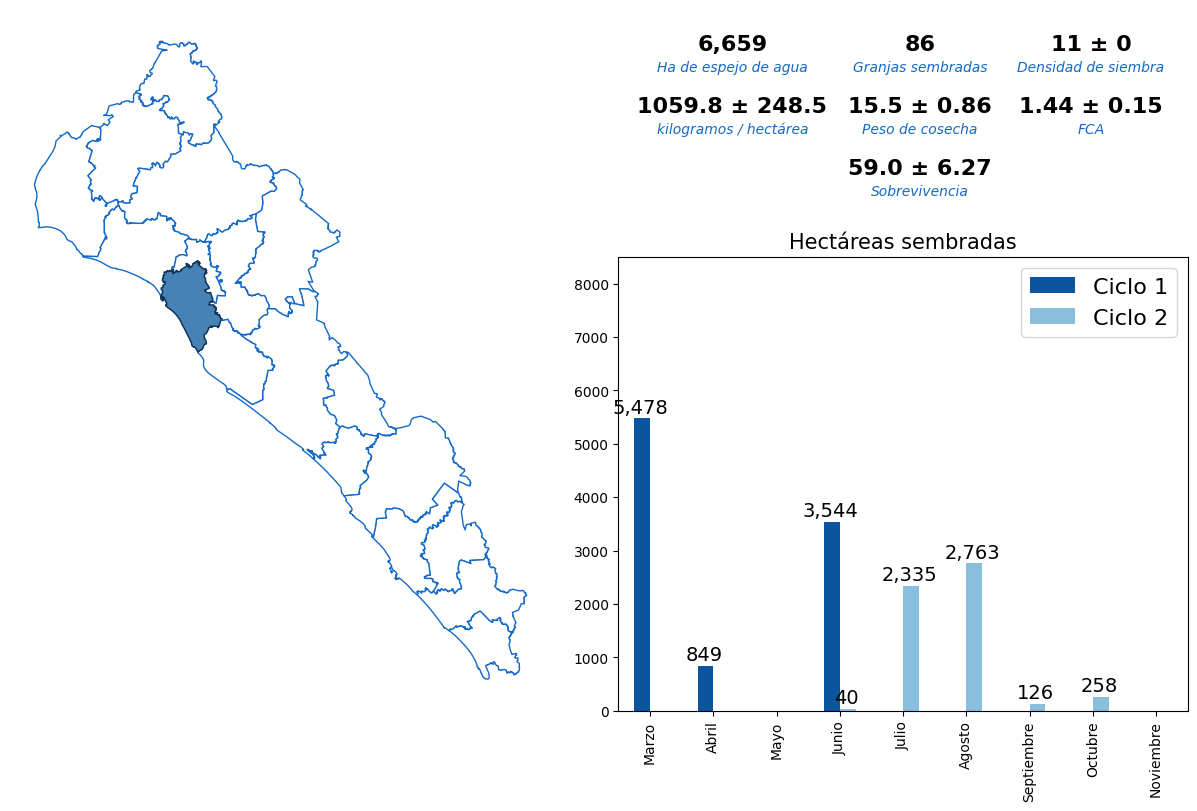

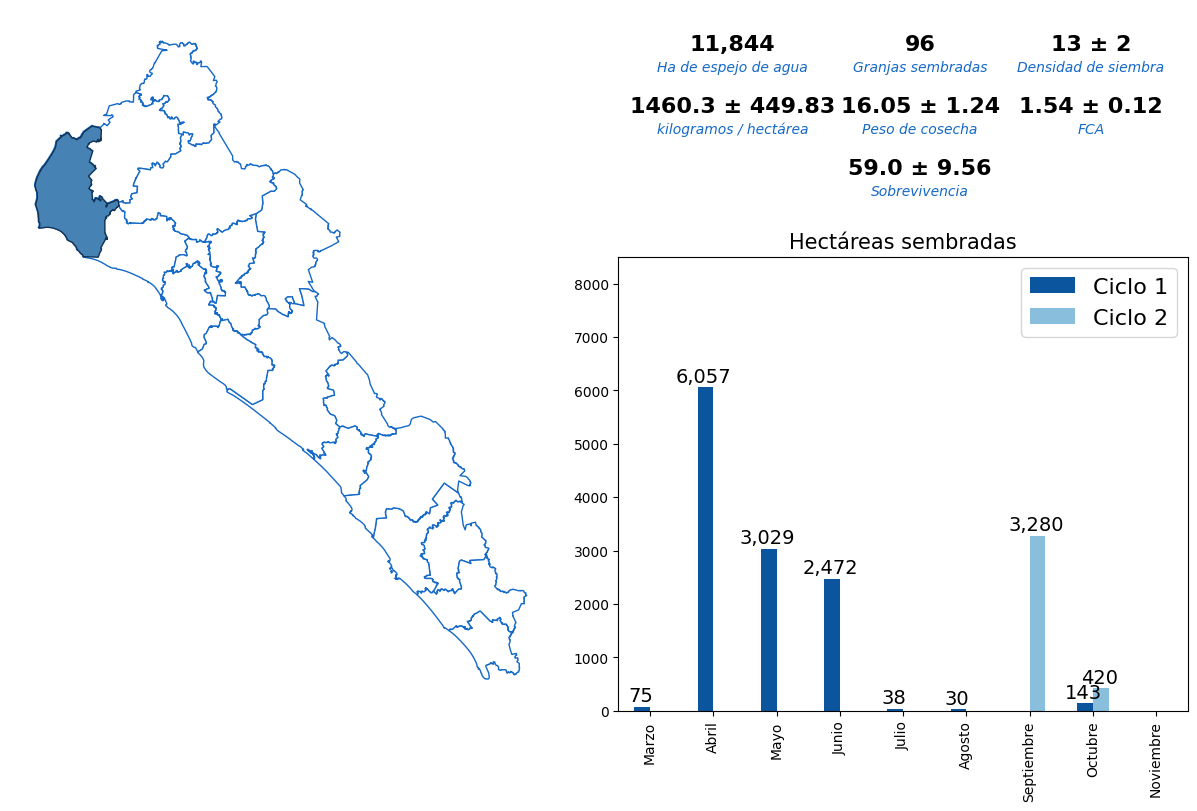

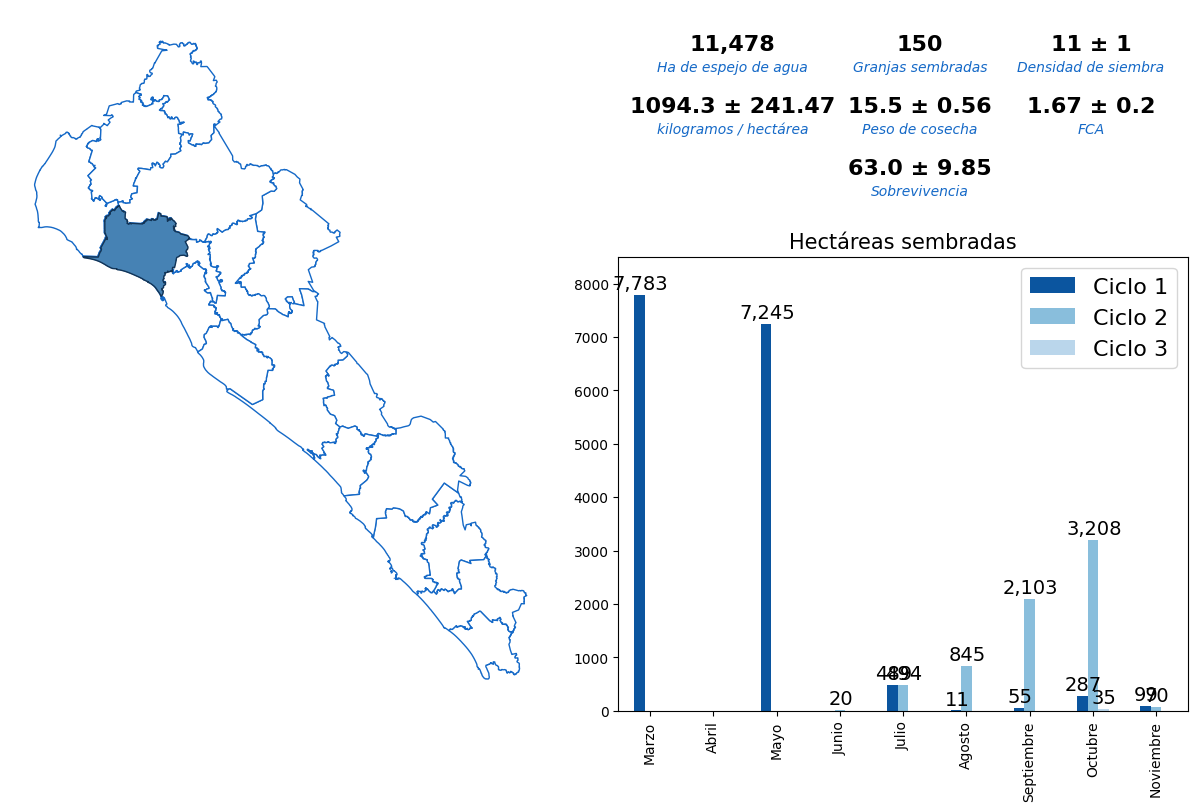

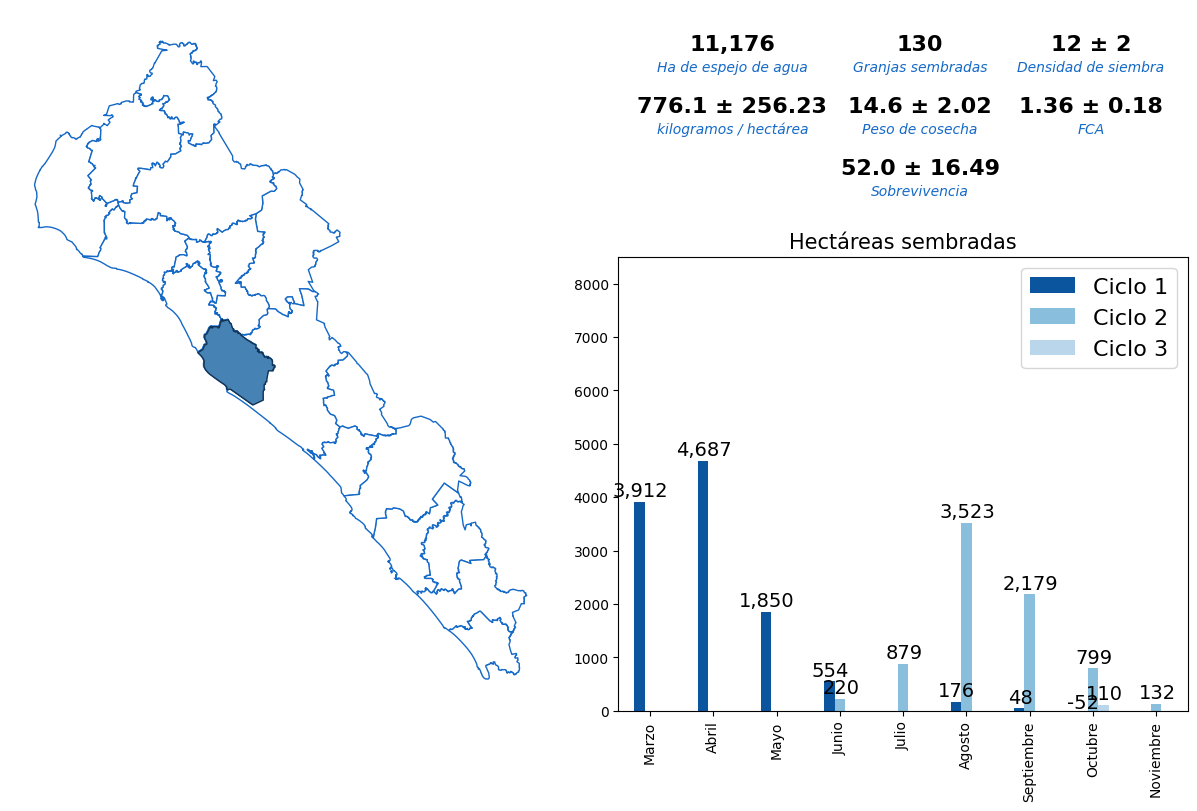

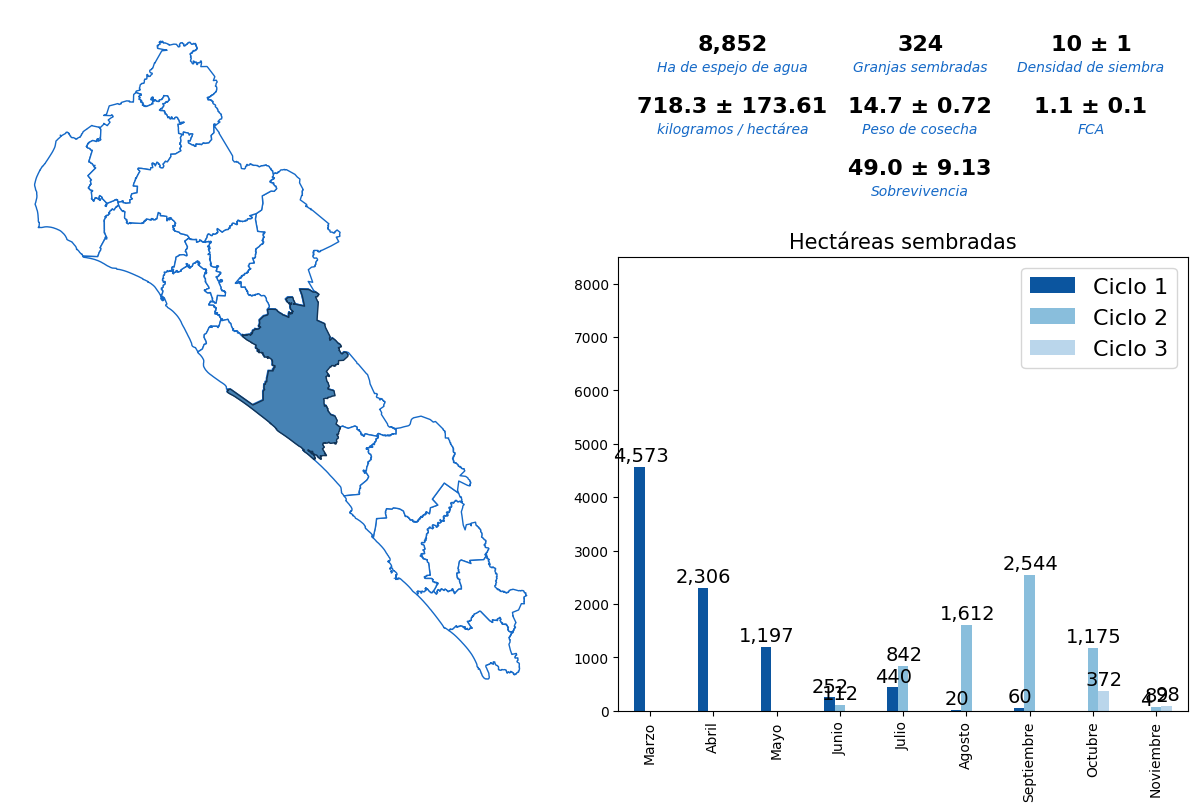

In [24]:
angostura.plots(), ahome.plots(), guasave.plots(), navolato.plots () , culiacan.plots()